# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Arial'; text-align:left; font-size:25px; font-weight:600; color: #EBEBEB"> Overview</p>
<center><img src="https://media.springernature.com/w580h326/nature-cms/uploads/collections/Vector-borne_disease_hero-93b52801cf986e92c30b7e364c7ab975.jpg" style="width:1000px;height:300px;"></center>

<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Arial; text-align:left">
    
<h3 align="left"><font color='#800080'>Introduction:</font></h3>

<ul>
    <li>Dataset is about Vector-borne diseases which are infections that are transmitted to humans and animals by blood-sucking arthropods such as mosquitoes, ticks, fleas, and sandflies.</li>
    <li>Target is to prognosis between 11 available disease based on the paitient's symptoms. Available diseases are: 
        <mark style='background-color: Gainsboro; font-weight:bold;'>Chikungunya</mark>, 
<mark style='background-color: Gainsboro; font-weight:bold;'>Dengue</mark>, 
<mark style='background-color: Gainsboro; font-weight:bold;'>Zika</mark>,
<mark style='background-color: Gainsboro; font-weight:bold;'>Yellow Fever</mark>
<mark style='background-color: Gainsboro; font-weight:bold;'>Raft Valley Fever</mark>,
<mark style='background-color: Gainsboro; font-weight:bold;'>West Nile Fever</mark>,
<mark style='background-color: Gainsboro; font-weight:bold;'>Malaria</mark>,
<mark style='background-color: Gainsboro; font-weight:bold;'>Tungiasis</mark>,
<mark style='background-color: Gainsboro; font-weight:bold;'>Japanese Encephalitis</mark>,
<mark style='background-color: Gainsboro; font-weight:bold;'>Plague</mark>,
<mark style='background-color: Gainsboro; font-weight:bold;'>Lyme Disease</mark></li>
      <li>This is a multiclass problem to prognosis between 11 Vector-borne diseases based on paitient's symptoms.</li>
</ul>    
    
<h3 align="left"><font color='#800080'>Abstract:</font></h3>

<ul>
    <li>It has been said that performance of the model could change when combining the original and playground datasets however we should change the labels of **prognosis** to consider '_' as the splitter.</li>
    <li>Xgboost was considered a the baseline model with stratified kfol cross validation MAP@3 score of **0.3505**.</li>
    <li>Permutation and feature importance were analysed to understand the pattern which features could be removed in furter studies to increase the score.</li>
    <li>n_splits and repeats fo cross validation were manipulated and 20 splits with 3 repeats was the highest cross val MAP@3 score with **0.3607**.</li>
    <li>Adding the original dataset helped to improve the Cross validation score and based on different number of splits and repeats 20 splits and 2 repeats has the highest CV score <mark style='background-color: Gainsboro; font-weight:bold;'>0.4524</mark>.</li>
    <li>Optuna was used to Tune hyperparameters of the Xgboost model to increase the cross validation score to <mark style='background-color: Gainsboro; font-weight:bold;'>0.4969</mark>.</li>
    <li>Some new features were added based on similarity of symptoms and Hierarchical clustering which lead to CV score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.4787</mark>.</li>
</ul> 
    
<h3 align="left"><font color='#800080'>Suggestions:</font></h3>
<ul>
    <li>Adding more features with featre engineering or maybe removing some of the features.</li>
    <li>Using other models and compare them with each other.</li>
</ul> 
</div>

# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Arial'; text-align:left; font-size:25px; font-weight:600; color: #EBEBEB"> Outline</p>
* [ 1. Import dataset and libraries ](#1)
* [ 2. EDA](#2)
* [ 3. Data Preparation](#3)
* [ 4. Modeling](#4)
* [ 5. Submission](#5)

<a id="1"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Arial'; text-align:left; font-size:25px; font-weight:600; color: #EBEBEB"> 1. Import dataset and libraries</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
import umap

from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold,GridSearchCV
from sklearn.model_selection import GridSearchCV
import optuna

from sklearn.inspection import permutation_importance

from scipy.cluster.hierarchy import linkage, dendrogram

# Model evaluaion libraries
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import make_scorer

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier,plot_importance
from sklearn.preprocessing import OrdinalEncoder


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Seed = 17

In [2]:
P_train_df = pd.read_csv('/kaggle/input/playground-series-s3e13/train.csv')
P_train_df.drop(columns=["id"], inplace=True)
test_df = pd.read_csv('/kaggle/input/playground-series-s3e13/test.csv')

O_train_df = pd.read_csv('/kaggle/input/vector-borne-disease-prediction/trainn.csv')
O_test_df = pd.read_csv('/kaggle/input/vector-borne-disease-prediction/testt.csv')

In [3]:
# Combining original and playground datasets
O_train_df['prognosis'] = O_train_df['prognosis'].str.replace(' ', '_')
O_test_df['prognosis'] = O_test_df['prognosis'].str.replace(' ', '_')
orig = pd.concat([O_train_df, O_test_df], axis=0)
train_df = pd.concat([P_train_df, orig], axis=0)

<a id="2"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Arial'; text-align:left; font-size:25px; font-weight:600; color: #EBEBEB"> 2. EDA</p>

<a id="2.1"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 2.1 Data summary</p>

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
def summary(df):
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} examples.")
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary["Duplicated"] = df.duplicated().sum()
    summary["Types"] = df.dtypes
#     summary.drop(labels="id", inplace=True)
    return summary

In [5]:
summary(P_train_df)

Dataset has 65 features and 707 examples.


Unique  Missing  Duplicated    Types
sudden_fever                2        0           0  float64
headache                    2        0           0  float64
mouth_bleed                 2        0           0  float64
nose_bleed                  2        0           0  float64
muscle_pain                 2        0           0  float64
joint_pain                  2        0           0  float64
vomiting                    2        0           0  float64
rash                        2        0           0  float64
diarrhea                    2        0           0  float64
hypotension                 2        0           0  float64
pleural_effusion            2        0           0  float64
ascites                     2        0           0  float64
gastro_bleeding             2        0           0  float64
swelling                    2        0           0  float64
nausea                      2        0           0  float64
chills                      2        0           0  float64
myalgia                     2        0           0  float64
digestion_trouble           2        0           0  float64
fatigue                     2        0           0  float64
skin_lesions                2        0           0  float64
stomach_pain                2        0           0  float64
orbital_pain                2        0           0  float64
neck_pain                   2        0           0  float64
weakness                    2        0           0  float64
back_pain                   2        0           0  float64
weight_loss                 2        0           0  float64
gum_bleed                   2        0           0  float64
jaundice                    2        0           0  float64
coma                        2        0           0  float64
diziness                    2        0           0  float64
inflammation                2        0           0  float64
red_eyes                    2        0           0  float64
loss_of_appetite            2        0           0  float64
urination_loss              2        0           0  float64
slow_heart_rate             2        0           0  float64
abdominal_pain              2        0           0  float64
light_sensitivity           2        0           0  float64
yellow_skin                 2        0           0  float64
yellow_eyes                 2        0           0  float64
facial_distortion           2        0           0  float64
microcephaly                2        0           0  float64
rigor                       2        0           0  float64
bitter_tongue               2        0           0  float64
convulsion                  2        0           0  float64
anemia                      2        0           0  float64
cocacola_urine              2        0           0  float64
hypoglycemia                2        0           0  float64
prostraction                2        0           0  float64
hyperpyrexia                2        0           0  float64
stiff_neck                  2        0           0  float64
irritability                2        0           0  float64
confusion                   2        0           0  float64
tremor                      2        0           0  float64
paralysis                   2        0           0  float64
lymph_swells                2        0           0  float64
breathing_restriction       2        0           0  float64
toe_inflammation            2        0           0  float64
finger_inflammation         2        0           0  float64
lips_irritation             2        0           0  float64
itchiness                   2        0           0  float64
ulcers                      2        0           0  float64
toenail_loss                2        0           0  float64
speech_problem              2        0           0  float64
bullseye_rash               2        0           0  float64
prognosis                  11        0           0   object

In [6]:
summary(test_df)

Dataset has 65 features and 303 examples.


Unique  Missing  Duplicated    Types
id                        303        0           0    int64
sudden_fever                2        0           0  float64
headache                    2        0           0  float64
mouth_bleed                 2        0           0  float64
nose_bleed                  2        0           0  float64
muscle_pain                 2        0           0  float64
joint_pain                  2        0           0  float64
vomiting                    2        0           0  float64
rash                        2        0           0  float64
diarrhea                    2        0           0  float64
hypotension                 2        0           0  float64
pleural_effusion            2        0           0  float64
ascites                     2        0           0  float64
gastro_bleeding             2        0           0  float64
swelling                    2        0           0  float64
nausea                      2        0           0  float64
chills                      2        0           0  float64
myalgia                     2        0           0  float64
digestion_trouble           2        0           0  float64
fatigue                     2        0           0  float64
skin_lesions                2        0           0  float64
stomach_pain                2        0           0  float64
orbital_pain                2        0           0  float64
neck_pain                   2        0           0  float64
weakness                    2        0           0  float64
back_pain                   2        0           0  float64
weight_loss                 2        0           0  float64
gum_bleed                   2        0           0  float64
jaundice                    2        0           0  float64
coma                        2        0           0  float64
diziness                    2        0           0  float64
inflammation                2        0           0  float64
red_eyes                    2        0           0  float64
loss_of_appetite            2        0           0  float64
urination_loss              2        0           0  float64
slow_heart_rate             2        0           0  float64
abdominal_pain              2        0           0  float64
light_sensitivity           2        0           0  float64
yellow_skin                 2        0           0  float64
yellow_eyes                 2        0           0  float64
facial_distortion           2        0           0  float64
microcephaly                2        0           0  float64
rigor                       2        0           0  float64
bitter_tongue               2        0           0  float64
convulsion                  2        0           0  float64
anemia                      2        0           0  float64
cocacola_urine              2        0           0  float64
hypoglycemia                2        0           0  float64
prostraction                2        0           0  float64
hyperpyrexia                2        0           0  float64
stiff_neck                  2        0           0  float64
irritability                2        0           0  float64
confusion                   2        0           0  float64
tremor                      2        0           0  float64
paralysis                   2        0           0  float64
lymph_swells                2        0           0  float64
breathing_restriction       2        0           0  float64
toe_inflammation            2        0           0  float64
finger_inflammation         2        0           0  float64
lips_irritation             2        0           0  float64
itchiness                   2        0           0  float64
ulcers                      2        0           0  float64
toenail_loss                2        0           0  float64
speech_problem              2        0           0  float64
bullseye_rash               2        0           0  float64

In [7]:
summary(train_df)

Dataset has 65 features and 970 examples.


Unique  Missing  Duplicated    Types
sudden_fever                2        0          11  float64
headache                    2        0          11  float64
mouth_bleed                 2        0          11  float64
nose_bleed                  2        0          11  float64
muscle_pain                 2        0          11  float64
joint_pain                  2        0          11  float64
vomiting                    2        0          11  float64
rash                        2        0          11  float64
diarrhea                    2        0          11  float64
hypotension                 2        0          11  float64
pleural_effusion            2        0          11  float64
ascites                     2        0          11  float64
gastro_bleeding             2        0          11  float64
swelling                    2        0          11  float64
nausea                      2        0          11  float64
chills                      2        0          11  float64
myalgia                     2        0          11  float64
digestion_trouble           2        0          11  float64
fatigue                     2        0          11  float64
skin_lesions                2        0          11  float64
stomach_pain                2        0          11  float64
orbital_pain                2        0          11  float64
neck_pain                   2        0          11  float64
weakness                    2        0          11  float64
back_pain                   2        0          11  float64
weight_loss                 2        0          11  float64
gum_bleed                   2        0          11  float64
jaundice                    2        0          11  float64
coma                        2        0          11  float64
diziness                    2        0          11  float64
inflammation                2        0          11  float64
red_eyes                    2        0          11  float64
loss_of_appetite            2        0          11  float64
urination_loss              2        0          11  float64
slow_heart_rate             2        0          11  float64
abdominal_pain              2        0          11  float64
light_sensitivity           2        0          11  float64
yellow_skin                 2        0          11  float64
yellow_eyes                 2        0          11  float64
facial_distortion           2        0          11  float64
microcephaly                2        0          11  float64
rigor                       2        0          11  float64
bitter_tongue               2        0          11  float64
convulsion                  2        0          11  float64
anemia                      2        0          11  float64
cocacola_urine              2        0          11  float64
hypoglycemia                2        0          11  float64
prostraction                2        0          11  float64
hyperpyrexia                2        0          11  float64
stiff_neck                  2        0          11  float64
irritability                2        0          11  float64
confusion                   2        0          11  float64
tremor                      2        0          11  float64
paralysis                   2        0          11  float64
lymph_swells                2        0          11  float64
breathing_restriction       2        0          11  float64
toe_inflammation            2        0          11  float64
finger_inflammation         2        0          11  float64
lips_irritation             2        0          11  float64
itchiness                   2        0          11  float64
ulcers                      2        0          11  float64
toenail_loss                2        0          11  float64
speech_problem              2        0          11  float64
bullseye_rash               2        0          11  float64
prognosis                  11        0          11   object

In [8]:
target = "prognosis"
features = [c for c in P_train_df.columns if c!=target]
# features.remove('id')
print(features)
for c in features:
    P_train_df[c] = P_train_df[c].astype(int)

['sudden_fever', 'headache', 'mouth_bleed', 'nose_bleed', 'muscle_pain', 'joint_pain', 'vomiting', 'rash', 'diarrhea', 'hypotension', 'pleural_effusion', 'ascites', 'gastro_bleeding', 'swelling', 'nausea', 'chills', 'myalgia', 'digestion_trouble', 'fatigue', 'skin_lesions', 'stomach_pain', 'orbital_pain', 'neck_pain', 'weakness', 'back_pain', 'weight_loss', 'gum_bleed', 'jaundice', 'coma', 'diziness', 'inflammation', 'red_eyes', 'loss_of_appetite', 'urination_loss', 'slow_heart_rate', 'abdominal_pain', 'light_sensitivity', 'yellow_skin', 'yellow_eyes', 'facial_distortion', 'microcephaly', 'rigor', 'bitter_tongue', 'convulsion', 'anemia', 'cocacola_urine', 'hypoglycemia', 'prostraction', 'hyperpyrexia', 'stiff_neck', 'irritability', 'confusion', 'tremor', 'paralysis', 'lymph_swells', 'breathing_restriction', 'toe_inflammation', 'finger_inflammation', 'lips_irritation', 'itchiness', 'ulcers', 'toenail_loss', 'speech_problem', 'bullseye_rash']


<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Arial; text-align:left">

<h3 align="left"><font color='#800080'>Insights:</font></h3>

- Playground training set has **707** training examples and **64** symptoms for paitients as features which are binary and **prognosis** is the target.
- Playground test set has **303** examples and Original training set has **252** training examples and Original test set has **11** examples by adding original dataframe to the training set it has **970** training example. 
- This is a multiclassification problem which the target is between 11 classes.
- Train and Test dataset has zero duplicated values.
- Train and Test dataset has zero Missing values.
- Features have been identified and playground train set features were changed from float to integers.

<a id="2.2"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 2.2 Target distribution</p>
Let's evaluate the dataset with a pie plot to see how many of each disease is in the datasete.

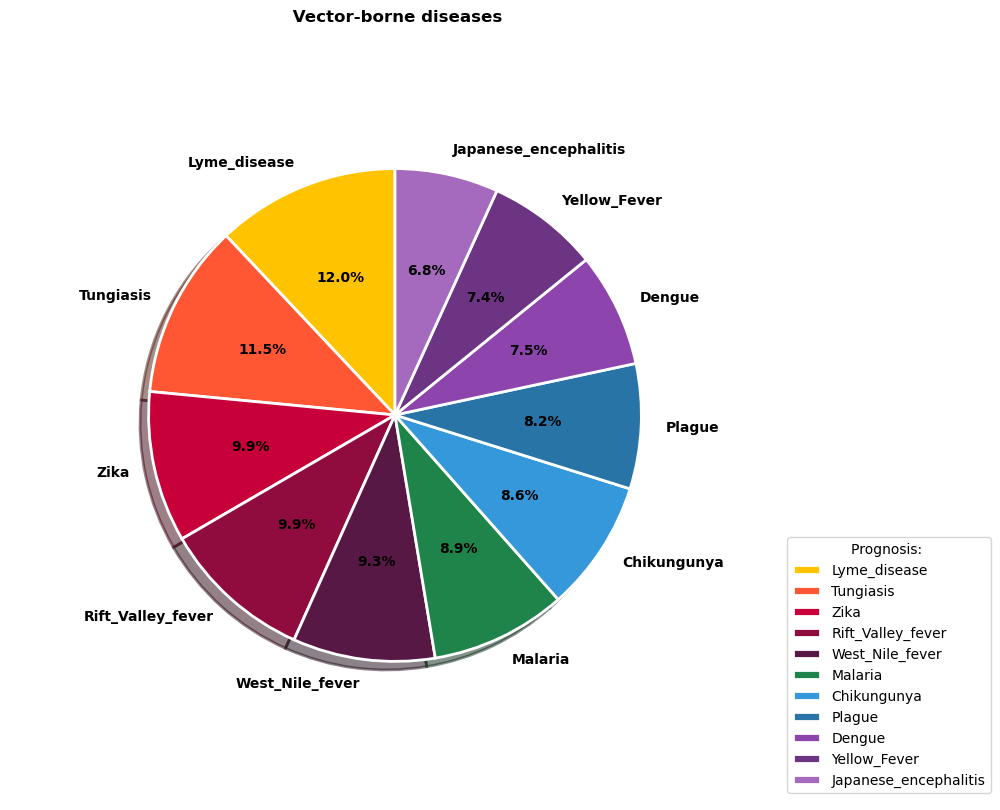

In [9]:
colorPal = ['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845', '#1E8449', '#3498DB', '#2874A6', '#8E44AD', '#6C3483', '#A569BD']
piee = P_train_df['prognosis'].value_counts()
mylabels = train_df['prognosis'].unique()
wedgeprops = {'linewidth': 2, 'edgecolor': 'white'}

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))


patches, texts, autotexts = ax.pie(piee, autopct='%1.1f%%', wedgeprops = wedgeprops,
                                  labels = mylabels, shadow = True,
                                  colors = colorPal, startangle = 90,
                                  radius = 0.8)

ax.legend(patches, mylabels,title="Prognosis: ", loc="lower left", fontsize=10, bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold")
plt.setp(texts, size=10, weight="bold")

ax.set_title(" Vector-borne diseases", fontsize = 12, weight="bold")

plt.show()

<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Arial; text-align:left">

<h3 align="left"><font color='#800080'>Insights:</font></h3>

- Target classes are pretty balanced in which the lowest one, **Japanese_encephalitis** has 6.8 % and the highest one,  **Lyme_disease** has  12.0 % distributions.

<a id="2.3"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 2.3 Features distribution</p>

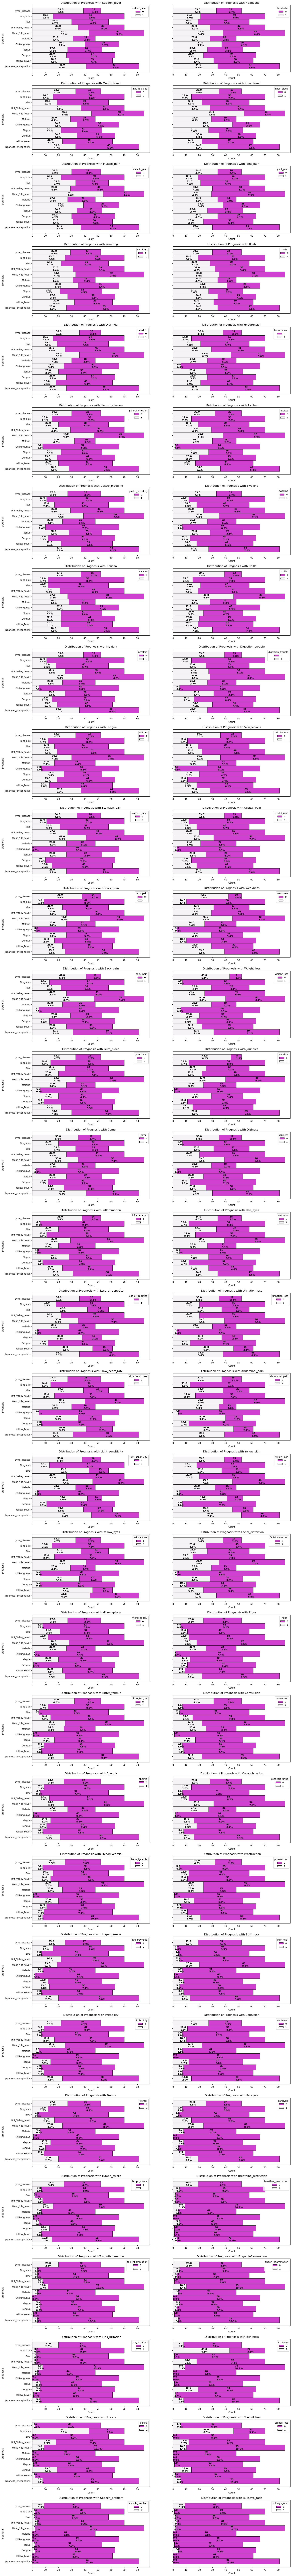

In [10]:
fig, axes = plt.subplots(nrows=32, ncols=2, figsize=(20,200), sharey=True)
for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.histplot(ax=ax, data=P_train_df, y="prognosis", hue=feature, multiple="stack", palette="light:m_r", edgecolor=".1", linewidth=1)
    ax.set_title(f"Distribution of Prognosis with {feature.capitalize()}")
    
    # Add count and percentage labels to each bar
    for patch in ax.patches:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_y() + patch.get_height() / 2
        count = patch.get_width()
        percent = count / len(P_train_df) * 100
        ax.text(x, y, f"{count}\n{percent:.1f}%", ha="left", va="center",fontweight='bold')

<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Arial; text-align:left">

<h3 align="left"><font color='#800080'>Insights:</font></h3>

- Every feature have been evaluated to understand which prognosis is more prone to a specific symptom.
- For instance **speech_problem** and **bullseye_rash** looks to be more common in paitients who have **lyme_disease**. **itchiness** and **Toenail_loss** are mostly seen in **tungiasis** paitients.
- Some symptoms are common between different paitients like **Headache**, **Nose_bleed** and **Mouth_bleed**.

<a id="2.4"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 2.4 Correlation Matrix</p>

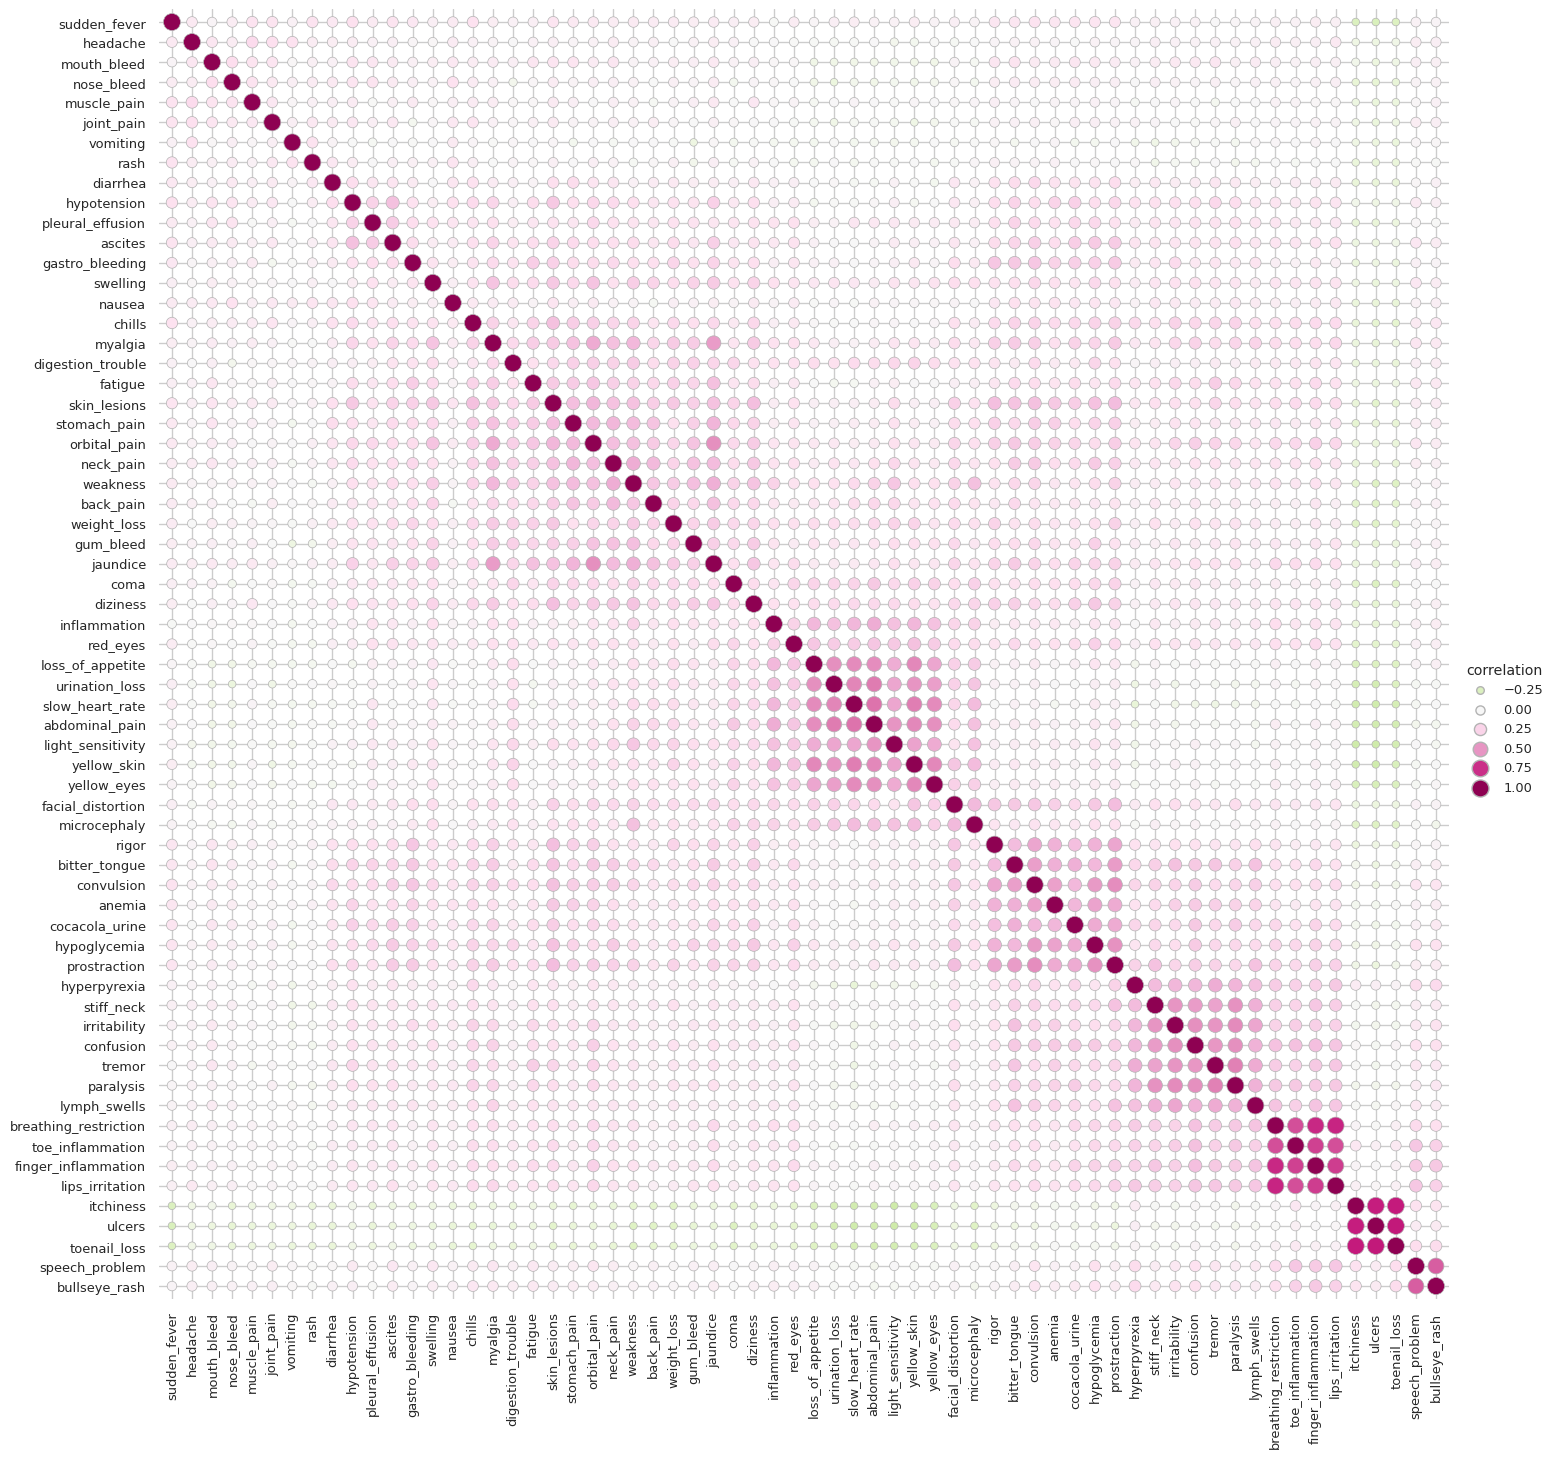

In [11]:
sns.set_theme(style="whitegrid", font_scale=0.85)

# Compute a correlation matrix and convert to long-form
corr_mat = P_train_df.corr()
# mask = np.tril(np.ones_like(corr_mat, dtype=bool))
# corr_mat = corr_mat.mask(mask)
corr_mat = corr_mat.stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="PiYG_r", hue_norm=(-1, 1), edgecolor=".7",
    height=15, sizes=(30, 150), size_norm=(-0.1, 0.8)
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.01)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

<a id="2.5"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 2.5 Dimensionality reduction</p>
Dimensionality reduction methods are to simplify the datasets with large features to understand the relations or patterns between features  and visualize high dimensional datasets. There are multiple approaches for dimensionality reduction UMAP and t_SNE are both good techniques that offer different advantages for instance UMAP is known to perform much faster. For extensive materials to understand UMAP, I suggest to read this article by Andy Coenen and Adam Pearce https://pair-code.github.io/understanding-umap/ and for further reading material for t_SNE you can read this blog https://distill.pub/2016/misread-tsne/. 

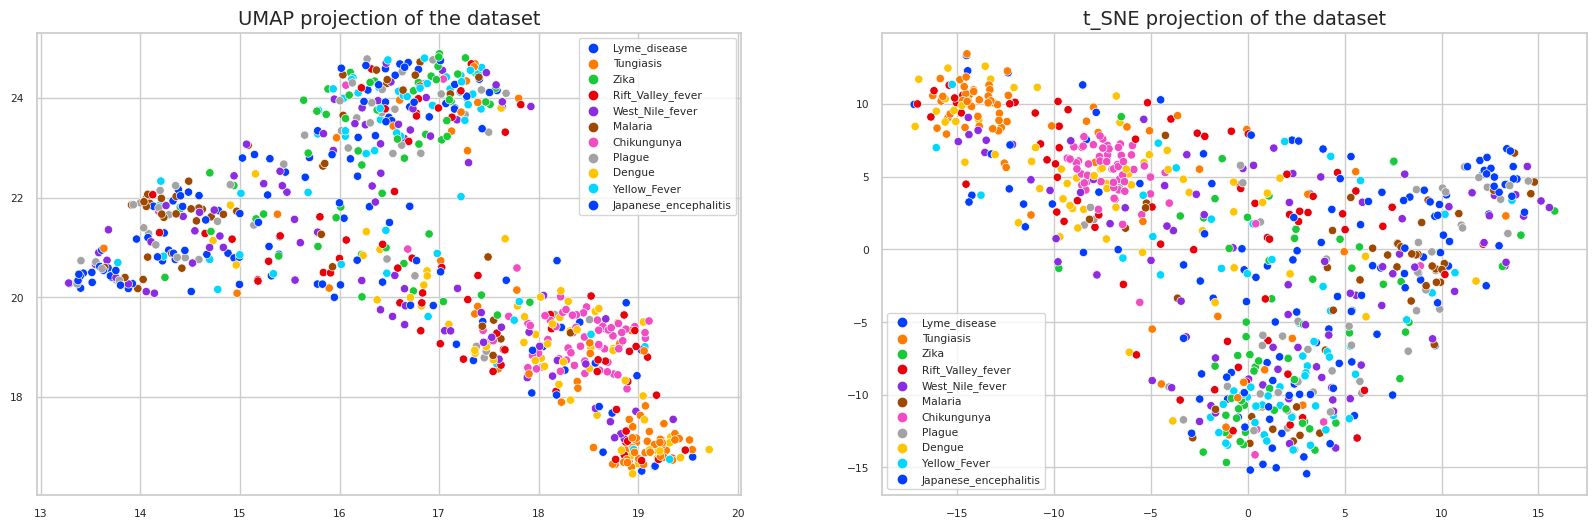

In [12]:
# Assign X & y
X = P_train_df.iloc[:,:-1].values
y = P_train_df.iloc[:,-1].values

# Fit UMAP model to reduce dimensionality to 2D
umap_model = umap.UMAP(n_components=2, n_neighbors = 70, min_dist=0.1, metric='euclidean', random_state=Seed)
umap_embed = umap_model.fit_transform(X)

# Apply t-SNE
tsne_embed = TSNE(n_components=2, n_iter=4000, n_iter_without_progress=800, perplexity=50, learning_rate='auto', init='pca', random_state=Seed).fit_transform(X)

# Visualize embeddings
sns.set_theme(style="whitegrid", font_scale=0.7)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6), squeeze=False)
sns.scatterplot(umap_embed, x= umap_embed[:, 0], y= umap_embed[:, 1], hue=y, palette='bright', ax=axes[0,0])
axes[0,0].set_title("UMAP projection of the dataset", fontsize=14)
sns.scatterplot(tsne_embed, x= tsne_embed[:, 0], y= tsne_embed[:, 1], hue=y, palette='bright', ax=axes[0,1])
axes[0,1].set_title("t_SNE projection of the dataset", fontsize=14)
plt.show()

<a id="3"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Arial'; text-align:left; font-size:25px; font-weight:600; color: #EBEBEB"> 3. Data Prepration</p>

In [13]:
# encoding categorical variables as integers
enc = OrdinalEncoder()
y = enc.fit_transform(P_train_df[['prognosis']])
X = P_train_df.iloc[:,:-1].values
X_sub = test_df.iloc[:,1:].values
# y = P_train_df.iloc[:,-1].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=Seed)


<a id="4"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Arial'; text-align:left; font-size:25px; font-weight:600; color: #EBEBEB"> 4. Modeling</p>
First of all based on <a href="https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code/notebook">the referenced notebook</a> by the competition, Mean average percision (MAP), for different relevant (correct) labels, is defined. For our dataset relevent labels are 3 therefore we call the metrics MAP@3. 

In [14]:
# Mean Average Precision MAP@k
# https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code/notebook

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
        score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    sorted_prob_ids = np.argsort(-predicted)
    topk_pred = sorted_prob_ids[:,:k]
    
    return np.mean([apk(a,p,k) for a,p in zip(actual, topk_pred)])

# Define cross-validation with MAP@3 scoring
mapk_scorer = make_scorer(mapk, greater_is_better=True, needs_proba=True)

In [15]:
# https://www.kaggle.com/code/wlifferth/generating-map-k-predictions
# find top 3 probabilities for each data
# Highest probabilities with argsort and negative because argsort sorts in ascending order
def top3(y_prob):
    sorted_prob_ids = np.argsort(-y_prob)
    top3_diseases_ids = sorted_prob_ids[:,:3]
    original_shape = top3_diseases_ids.shape
    top3_diseases = enc.inverse_transform(top3_diseases_ids.reshape(-1,1))
    top3_diseases = top3_diseases.reshape(original_shape)
    return top3_diseases

<a id="4.1"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 4.1 Logistic regression</p>
This is a simple implementation to evaluate a simplest possible approach which turns out to have a `0.3256` MAP@3 score.

In [16]:
# # Define the classifier
# lr_clf = LogisticRegression()

# # set up cross-validation
# kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=Seed)

# # Define cross-validation with MAP@3 scoring
# mapk_scorer = make_scorer(mapk, greater_is_better=True, needs_proba=True)
# scores = cross_val_score(lr_clf, X, y, cv=kfold, scoring=mapk_scorer)
# log_loss_scores = cross_val_score(lr_clf, X, y, cv=kfold, scoring='neg_log_loss')

# # Print the average MAP@3 score over kfold cross-validation
# print("MAP@3: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
# print("Log_loss: %0.2f (+/- %0.4f)" % (-log_loss_scores.mean(), log_loss_scores.std() * 2))

<a id="4.2"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 4.2 Baseline Model with XGboost</p>
`multi:softmax` is a multiclass classification objective that outputs the class label with the highest probability. `multi:softprob`, on the other hand, returns the probabilities of each class label. This objective also uses the softmax function to calculate the probabilities of each class label, but instead of selecting the label with the highest probability, it outputs the probabilities of all class labels. LB score for this model turned out to be `0.3664`.

In [17]:
# Define the classifier
xgb_clf = XGBClassifier(objective='multi:softprob',random_state=Seed, tree_method='gpu_hist')

# set up cross-validation
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=Seed)


scores = cross_val_score(xgb_clf, X, y, cv=kfold, scoring=mapk_scorer)
log_loss_scores = cross_val_score(xgb_clf, X, y, cv=kfold, scoring='neg_log_loss')

# Print the average MAP@3 score over kfold cross-validation
print("MAP@3: %0.5f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
print("Log_loss: %0.5f (+/- %0.4f)" % (-log_loss_scores.mean(), log_loss_scores.std() * 2))

MAP@3: 0.33682 (+/- 0.0555)
Log_loss: 2.50199 (+/- 0.2857)


In [18]:
n_splits = 5
n_repeats = 10
kfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=Seed)
# Fitting the model
model_scores,log_loss_scores,acc_scores = [],[],[]
importance_train,importance_val = [],[]
labels = P_train_df.columns[:-1]

models_ = []
test_preds = np.zeros((len(X_sub),11))

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X,y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    xgb_clf = XGBClassifier(objective='multi:softprob',random_state=Seed, tree_method='gpu_hist')
    xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
    models_.append(xgb_clf)
    
    # Prediction of probability
    y_prob = xgb_clf.predict_proba(X_val)
    y_pred = xgb_clf.predict(X_val)
    test_pred = xgb_clf.predict_proba(X_sub)
    test_preds += test_pred / (n_splits*n_repeats)
    
    # Evaluation different metrics
    accuracy = xgb_clf.score(X_val, y_val)
    map3 = mapk(y_val,y_prob)
    logloss = log_loss(y_val,y_prob)
    model_scores.append(map3)
    log_loss_scores.append(logloss)
    acc_scores.append(accuracy)
    
    # Print metrics
    print(f'Fold {fold_idx+1}: MAP@3 score = {map3:.4f}   Log_Loss scores = {logloss:.4f}     Accuracy scores = {accuracy:.4f}')
    
    # Compute permutation importances
    result_train = permutation_importance(xgb_clf, X_train, y_train, scoring='neg_log_loss', n_repeats=10, random_state=Seed)
    result_val = permutation_importance(xgb_clf, X_val, y_val, scoring='neg_log_loss', n_repeats=10, random_state=Seed)

    # Store feature importances
    # Sort index
    sorted_perm_train_idx = result_train.importances_mean.argsort()
    sorted_perm_val_idx = result_val.importances_mean.argsort()
    
    perm_train = pd.DataFrame(result_train.importances[sorted_perm_train_idx].T,columns=labels[sorted_perm_train_idx],)
    perm_val = pd.DataFrame(result_val.importances[sorted_perm_val_idx].T,columns=labels[sorted_perm_val_idx],)
    
    importance_train.append(perm_train)
    importance_val.append(perm_val)
    
mean_scores = np.mean(model_scores)
mean_log_loss_scores = np.mean(log_loss_scores)
mean_acc_scores = np.mean(acc_scores)
print(f'{"_" * 80}\n Mean MAP@3 score: {mean_scores:.4f} (+/- {np.std(model_scores)**2})  Mean Log_Loss score: {mean_log_loss_scores:.4f}   Mean Accuracy score: {mean_acc_scores:.4f}')

Fold 1: MAP@3 score = 0.4284   Log_Loss scores = 1.9322     Accuracy scores = 0.3732
Fold 2: MAP@3 score = 0.3521   Log_Loss scores = 2.0048     Accuracy scores = 0.3239
Fold 3: MAP@3 score = 0.3511   Log_Loss scores = 1.9983     Accuracy scores = 0.3191
Fold 4: MAP@3 score = 0.3392   Log_Loss scores = 2.0455     Accuracy scores = 0.2624
Fold 5: MAP@3 score = 0.3392   Log_Loss scores = 1.9694     Accuracy scores = 0.2837
Fold 6: MAP@3 score = 0.3157   Log_Loss scores = 2.0908     Accuracy scores = 0.2465
Fold 7: MAP@3 score = 0.3568   Log_Loss scores = 1.9702     Accuracy scores = 0.3169
Fold 8: MAP@3 score = 0.3511   Log_Loss scores = 2.0073     Accuracy scores = 0.3191
Fold 9: MAP@3 score = 0.3274   Log_Loss scores = 2.0420     Accuracy scores = 0.2766
Fold 10: MAP@3 score = 0.3522   Log_Loss scores = 2.0112     Accuracy scores = 0.3262
Fold 11: MAP@3 score = 0.3650   Log_Loss scores = 1.9580     Accuracy scores = 0.3028
Fold 12: MAP@3 score = 0.3099   Log_Loss scores = 2.0928     Ac

<a id="4.3"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 4.3 Tune XGBoost without adding the original set and feature engineering</p>


<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Arial; text-align:left">

<h3 align="left"><font color='#800080'>Insights:</font></h3>
These are results when we are not adding the original dataset:

- Baseline XGboost model with Stratified Kfold and with 5 splits with 10 repeats have CV score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.3392</mark> and LB score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.34105</mark>
- Tunned XGboost model with Stratified Kfold and with 5 splits with 10 repeats have CV score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.3651</mark>
- Baseline XGboost model with Stratified Kfold and with 10 splits with 10 repeats have CV score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.3516</mark>
- Tunned XGboost model with Stratified Kfold and with 10 splits with 10 repeats have CV score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.3753</mark>

<a id="4.4"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 4.4 Permutation and Feature Importance</p>
`Permutation importance` is a technique used for feature selection and to understand the importance of features in a machine learning model. It works by randomly permuting the values of a feature and observing the effect on the model's performance. If permuting a feature decreases the model's performance significantly, it indicates that the feature is important. `Feature importance` focuses on the contribution of each feature to the model, while permutation importance assesses the impact of each feature by measuring the decrease in model performance when that feature is removed. 

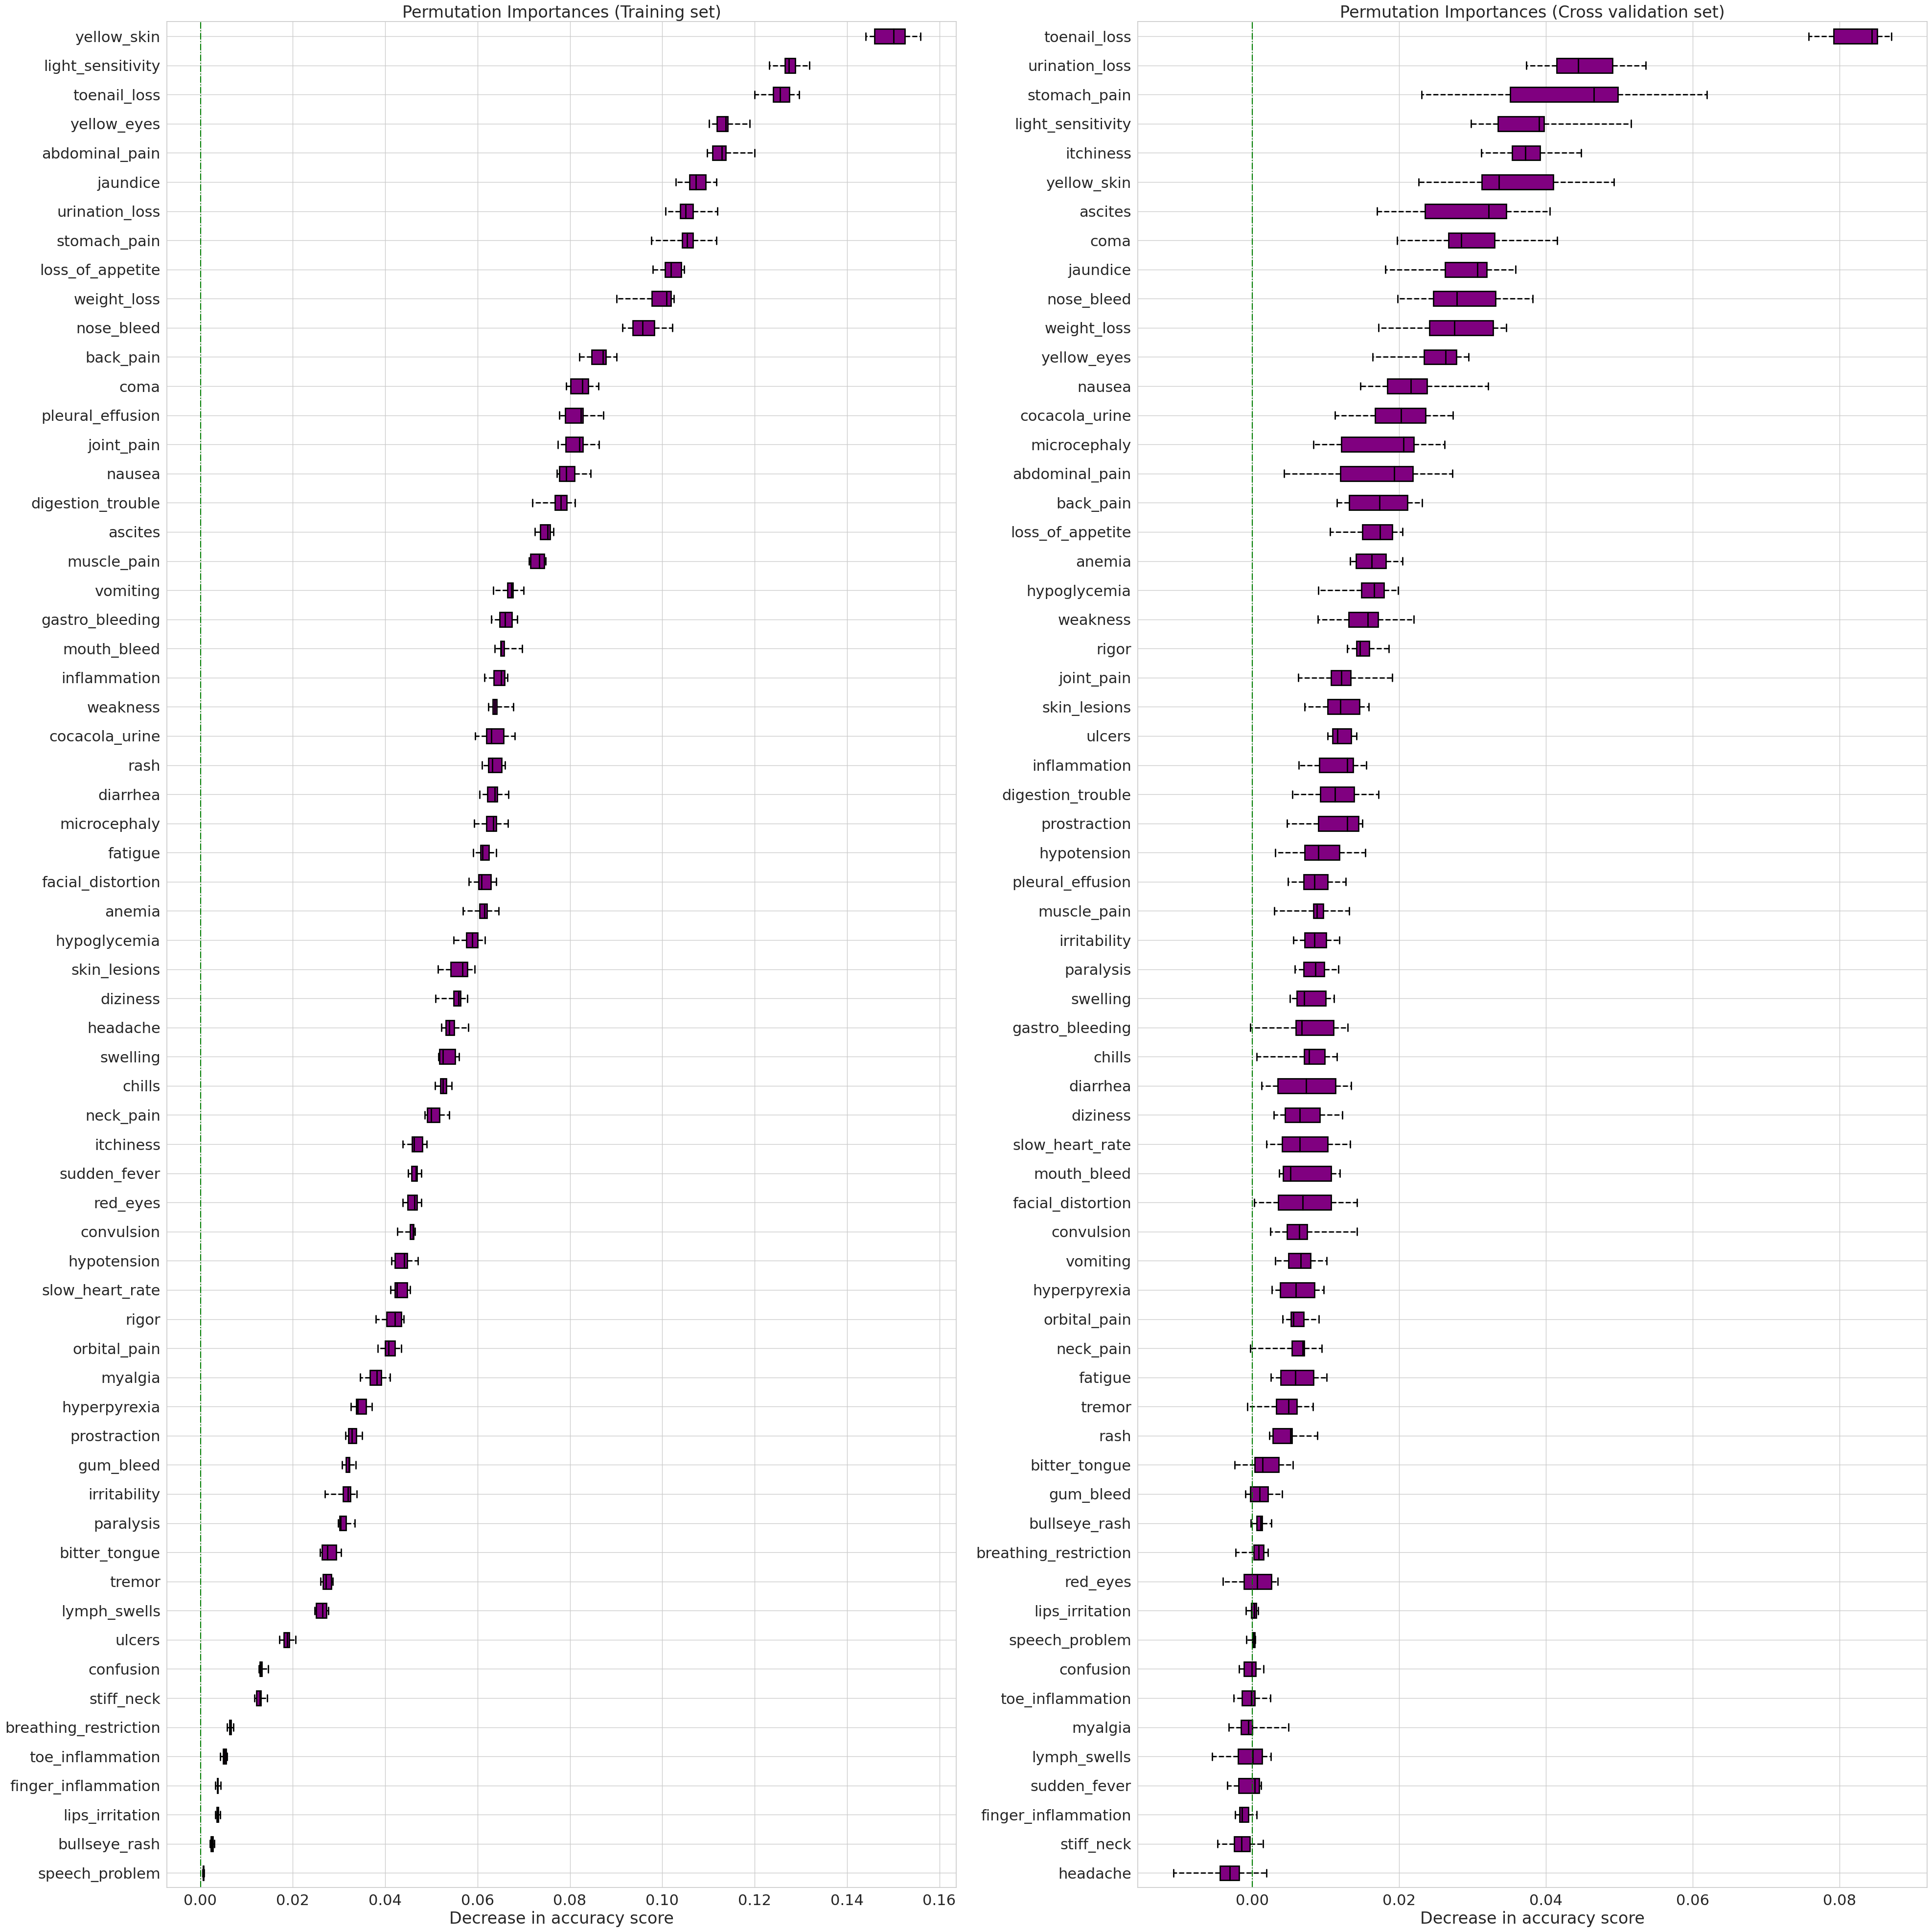

In [19]:
''' For each fold we have (10*64) values for permutation importance and we are going to get the mean of these 
folds into a single dataframe then sorting the dataframe based on the mean value between 10 permutation_importances'''

mean_importance_train = pd.DataFrame(columns=features)
n = len(importance_train[0])
for feature in features:
    num = 0.0
    for i in range (n):
        num += importance_train[i][feature]
    mean_importance_train[feature] = num / n
sorted_mean_importance_train = mean_importance_train[mean_importance_train.mean().sort_values().index]  

# ******************************************

mean_importance_val = pd.DataFrame(columns=features)
n = len(importance_val[0])
for feature in features:
    num = 0.0
    for i in range (n):
        num += importance_val[i][feature]
    mean_importance_val[feature] = num / n
sorted_mean_importance_val = mean_importance_val[mean_importance_val.mean().sort_values().index]    
# ******************************************

sns.set_theme(style="whitegrid", font_scale=2)
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', figsize=(40, 40))

boxprops = {'linestyle': '-', 'facecolor': 'purple', 'edgecolor': 'black', 'linewidth': 2.0}
whiskerprops = {'linestyle': '--', 'color': 'black', 'linewidth': 2.0}
capprops = {'color': 'black', 'linewidth': 2.0}
medianprops = {'color': 'black', 'linewidth': 2.0}

sorted_mean_importance_train.plot.box(patch_artist=True, vert=False, whis=10, ax=ax1, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)
ax1.set_title("Permutation Importances (Training set)")
ax1.axvline(x=0, color="green", linestyle="-.")
ax1.set_xlabel("Decrease in accuracy score")

sorted_mean_importance_val.plot.box(patch_artist=True, vert=False, whis=10, ax=ax2, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)
ax2.set_title("Permutation Importances (Cross validation set)")
ax2.axvline(x=0, color="green", linestyle="-.")
ax2.set_xlabel("Decrease in accuracy score")

plt.tight_layout()

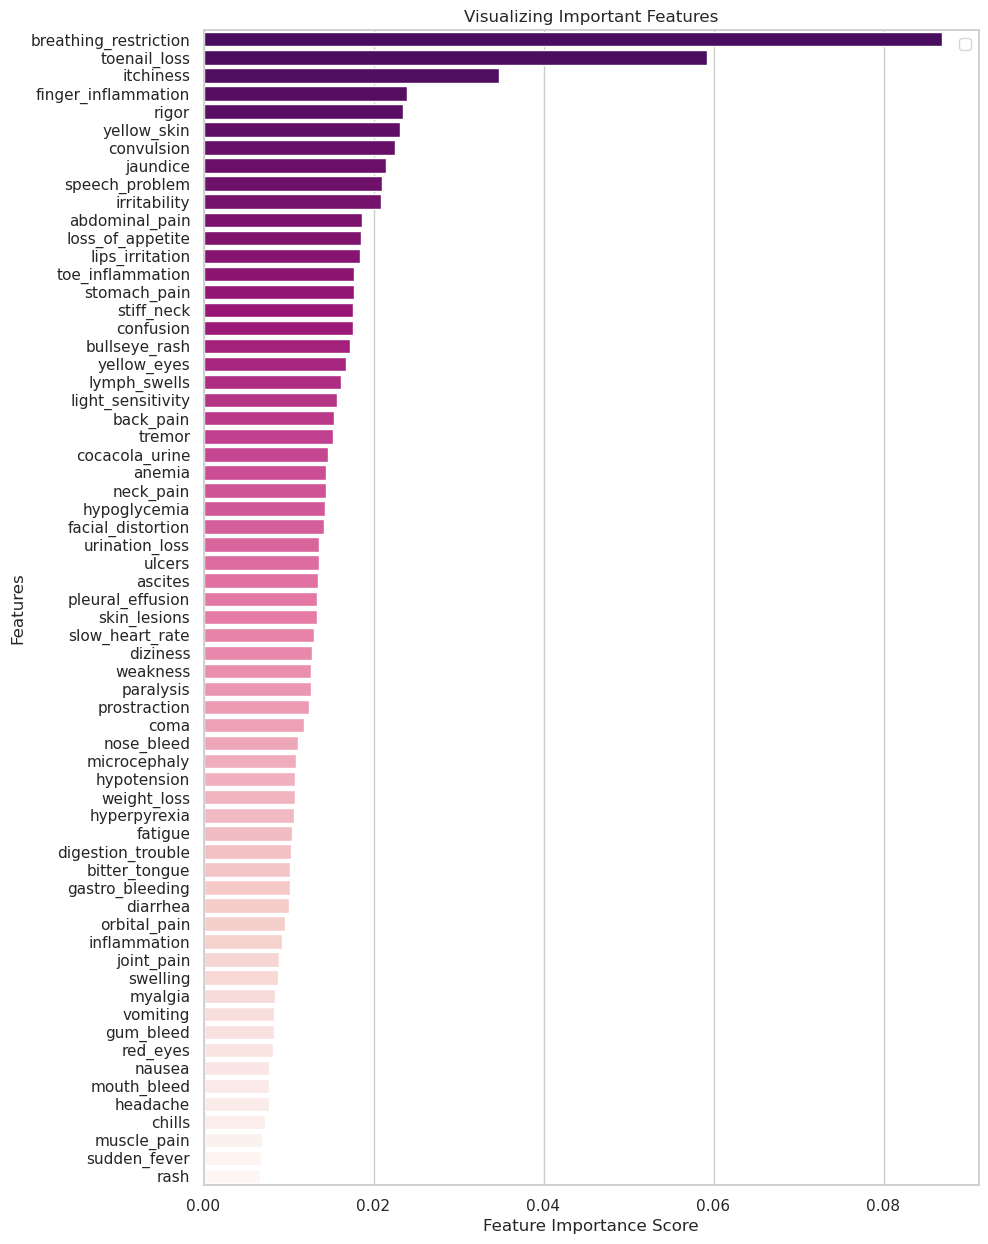

In [20]:
feature_imp = pd.Series(xgb_clf.feature_importances_, index=labels).sort_values(ascending=False)

# Creating a bar plot
sns.set_theme(style="whitegrid", font_scale=1)
plt.figure(figsize=(10,15))
sns.barplot(x=feature_imp, y=feature_imp.index, palette='RdPu_r')

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Arial; text-align:left">

<h3 align="left"><font color='#800080'>Insights:</font></h3>

- Permutation importance for training set was plotted and results showed that these five features had the most effect: <mark style='background-color: Gainsboro; font-weight:bold;'>yellow_skin</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>toneil_loss</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>light_sensitivity</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>yellow_eyes</mark> and <mark style='background-color: Gainsboro; font-weight:bold;'>urination_loss</mark>.
- Least important features base on permutatio importance are <mark style='background-color: Gainsboro; font-weight:bold;'>speech_problem</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>bullseye_rash</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>toe_inflammation</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>finger_inflammation</mark> and <mark style='background-color: Gainsboro; font-weight:bold;'>breathing_restriction</mark>.
- Permutation importance for cross validation suggest that these are the most important features: <mark style='background-color: Gainsboro; font-weight:bold;'>toneil_loss</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>stomach_problem</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>urination_loss</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>light_sensitivity</mark> and <mark style='background-color: Gainsboro; font-weight:bold;'>itchiness</mark>.
- Least important features based on permutation importance for croos validation are: <mark style='background-color: Gainsboro; font-weight:bold;'>vomiting</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>toe_inflammation</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>finger_inflammation</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>neck_pain</mark> and <mark style='background-color: Gainsboro; font-weight:bold;'>mylagia</mark>.
- Based on the feature importance only these five features are more important than others: <mark style='background-color: Gainsboro; font-weight:bold;'>toneil_loss</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>finger_inflammation</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>Speech_problem</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>itchiness</mark> and <mark style='background-color: Gainsboro; font-weight:bold;'>jaundice</mark>.
- Least important features based on the feature importance are: <mark style='background-color: Gainsboro; font-weight:bold;'>sudden_fever</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>headache</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>rash</mark>, <mark style='background-color: Gainsboro; font-weight:bold;'>bullseye_rash</mark> and <mark style='background-color: Gainsboro; font-weight:bold;'>mouth_bleed</mark>.



<a id="4.5"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 4.5 Manipulating the cross validation</p>
Based on the size of the dataset in this section we are going to change the number of folds to evaluate the percision of the model.

In [21]:
# def cv_eval(X, y, splits, repeats):
#     # prepare the cross-validation procedure
#     cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=Seed)
#     # create model

#     model = XGBClassifier(objective='multi:softprob', n_jobs=-1, random_state=Seed)
#     # evaluate model
#     scores = cross_val_score(model, X, y, scoring=mapk_scorer, cv=cv, n_jobs=-1)
#     return scores

# repeats = [2,3,4,5,7]
# splits = [5,10,20]
# scores_dict = {}
# for s in splits:
#     for r in repeats:
#         scores = cv_eval(X, y, s, r)
#         scores_dict[(s, r)] = scores
#         print(f'n_spits={s}, n_repeats={r}, mean score={np.mean(scores):.4f} (+/- {np.std(scores)**2:.4f})')
        
# # Find the best score and its corresponding parameters
# best_score = None
# best_params = None
# for params, scores in scores_dict.items():
#     mean_score = np.mean(scores)
#     if best_score is None or mean_score > best_score:
#         best_score = mean_score
#         best_params = params

# # Print the results
# print('*'*40)
# print('Best score:', best_score)
# print('Best params:', best_params)

In [22]:
# # Plot results
# plt.figure(figsize=(15,6))
# plt.boxplot(scores_dict.values(), labels=[name for name in scores_dict.keys()], showmeans=True);
# plt.ylabel('MAP@3',fontweight='bold')
# plt.xlabel('(splits,repeats)',fontweight='bold')
# plt.show()

In [23]:
# kfold = RepeatedStratifiedKFold(n_splits=20, n_repeats=3, random_state=Seed)
# model = XGBClassifier(objective='multi:softprob', n_jobs=-1, random_state=Seed)

In [24]:
# # Fitting the model
# model_scores,log_loss_scores,acc_scores = [],[],[]
# labels = P_train_df.columns[1:-1]

    
# for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X,y)):
#     X_train, X_val = X[train_idx], X[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]
#     model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
    
#     # Prediction of probability
#     y_prob = model.predict_proba(X_val)
#     y_pred = model.predict(X_val)
    
#     # Evaluation different metrics
#     accuracy = model.score(X_val, y_val)
#     map3 = mapk(y_val,y_prob)
#     logloss = log_loss(y_val,y_prob)
#     model_scores.append(map3)
#     log_loss_scores.append(logloss)
#     acc_scores.append(logloss)
    
#     # Print metrics
#     print(f'Fold {fold_idx+1}: MAP@3 score = {map3:.4f}   Log_Loss scores = {logloss:.4f}     Accuracy scores = {accuracy:.4f}')
    

# mean_scores = np.mean(model_scores)
# mean_log_loss_scores = np.mean(log_loss_scores)
# mean_acc_scores = np.mean(acc_scores)
# print(f'{"_" * 80}\n Mean MAP@3 score: {mean_scores:.4f}  Mean Log_Loss score: {mean_log_loss_scores:.4f}   Mean Accuracy score: {mean_acc_scores:.4f}')

<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Arial; text-align:left">

<h3 align="left"><font color='#800080'>Insights:</font></h3>

- Changing values of splits and repeats for stratified kfold cross validation model showed that 20 splits with 3 repeats gave the highest score with the baseline Xgboost model.
- Model was fitted and error metrics were evaluated and turned out Xgboost with this cross cvalidation setup gave <mark style='background-color: Gainsboro; font-weight:bold;'>0.3607</mark> MAP@3 score however my LB score was <mark style='background-color: Gainsboro; font-weight:bold;'>0.3123</mark>.
- In order to achieve more percision another values for split and repeats is going to be used for example 5 splits and 10 repeats resulted in CV score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.3392</mark> and LB score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.3374</mark>.


<a id="4.6"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 4.6 Adding original dataset and some featue engineering </p>

**Hierarchical clustering** is a clustering method used in machine learning to group together similar data points based on their pairwise distances. The goal of hierarchical clustering is to produce a hierarchy of nested clusters, with the clusters at the bottom of the hierarchy being individual data points and the clusters at the top of the hierarchy representing large groups of similar data points.

To cluster similar symptoms using hierarchical clustering, we need to first define a distance metric that measures the similarity between any two symptoms. A commonly used distance metric is Euclidean distance, which measures the straight-line distance between two points in a multi-dimensional space. Cosine distance is another commonly used distance metric, which measures the angle between two vectors in a multi-dimensional space.

Once we have defined a distance metric, we can calculate the pairwise distance between each symptom. This creates a distance matrix, which is a square matrix that contains the pairwise distances between all symptoms.

Next, we use a linkage method to determine the distance between clusters. The linkage method determines how the distance between two clusters is calculated, and there are several different linkage methods available. Two commonly used linkage methods are Ward linkage and complete linkage.

Ward linkage is a hierarchical clustering method that aims to minimize the variance within each cluster. It calculates the distance between two clusters by looking at how much the variance within each cluster would increase if the two clusters were merged. This method tends to produce clusters that are more balanced in size and shape.

Complete linkage, on the other hand, calculates the distance between two clusters by looking at the maximum distance between any two points in the two clusters. This method tends to produce clusters that are more compact and spherical.

By using a combination of distance metric and linkage method, we can create a dendrogram that shows the hierarchical clustering of symptoms. The dendrogram is a tree-like diagram that shows how the individual symptoms are grouped together into clusters. The height of the branches in the dendrogram represents the distance between clusters, with longer branches indicating greater distances.

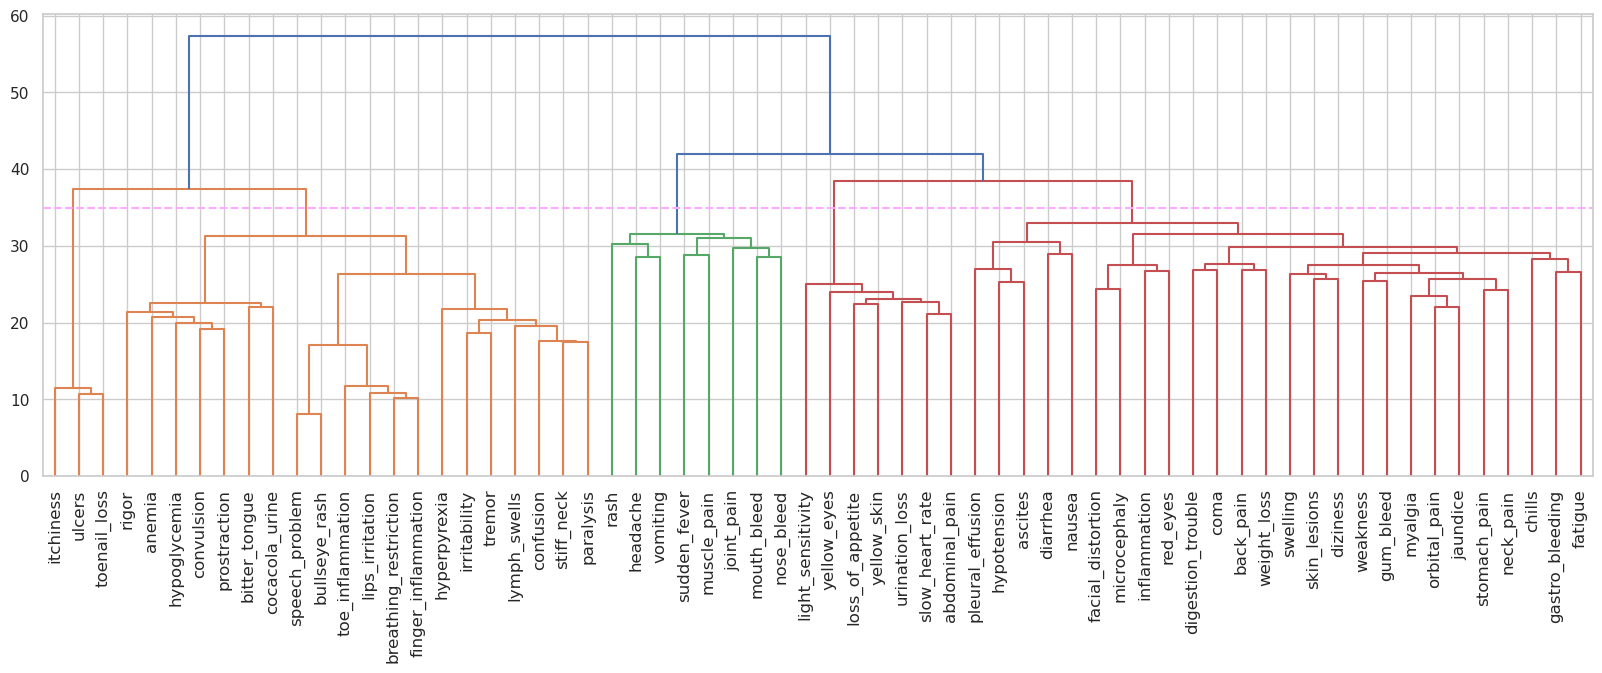

In [25]:
# Hierarchical clustering
symptoms = features

# Define the threshold distance value
threshold = 35

# Create a binary matrix where rows represent symptoms and columns represent patients
data = train_df[features].values.T

# Calculate the pairwise distance between symptoms using Euclidean distance
dist = np.sqrt(np.sum((data[:, np.newaxis, :] - data[np.newaxis, :, :]) ** 2, axis=-1))

# Perform hierarchical clustering using complete linkage
linkage_matrix = linkage(dist, method='complete')

# Plot the dendrogram to visualize the clustering
fig,ax = plt.subplots(figsize=(20,6))
dendrogram(linkage_matrix, labels=symptoms, ax=ax)
ax.tick_params(axis='x', labelsize=12)
ax.axhline(y=threshold, color='#FCACFF', linestyle='--')

In [26]:
from scipy.cluster.hierarchy import fcluster



# Extract the same cluster symptoms using the fcluster function
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Create a dictionary to store the symptoms for each cluster
cluster_symptoms = {}
for symptom, cluster in zip(symptoms, clusters):
    if cluster not in cluster_symptoms:
        cluster_symptoms[cluster] = [f"'{symptom}'"]
    else:
        cluster_symptoms[cluster].append(f"'{symptom}'")

# Print the symptoms for each cluster
for cluster, symptoms in cluster_symptoms.items():
    print(f"Cluster{cluster}= [ {', '.join(symptoms)}]")

Cluster3= [ 'sudden_fever', 'headache', 'mouth_bleed', 'nose_bleed', 'muscle_pain', 'joint_pain', 'vomiting', 'rash']
Cluster5= [ 'diarrhea', 'hypotension', 'pleural_effusion', 'ascites', 'gastro_bleeding', 'swelling', 'nausea', 'chills', 'myalgia', 'digestion_trouble', 'fatigue', 'skin_lesions', 'stomach_pain', 'orbital_pain', 'neck_pain', 'weakness', 'back_pain', 'weight_loss', 'gum_bleed', 'jaundice', 'coma', 'diziness', 'inflammation', 'red_eyes', 'facial_distortion', 'microcephaly']
Cluster4= [ 'loss_of_appetite', 'urination_loss', 'slow_heart_rate', 'abdominal_pain', 'light_sensitivity', 'yellow_skin', 'yellow_eyes']
Cluster2= [ 'rigor', 'bitter_tongue', 'convulsion', 'anemia', 'cocacola_urine', 'hypoglycemia', 'prostraction', 'hyperpyrexia', 'stiff_neck', 'irritability', 'confusion', 'tremor', 'paralysis', 'lymph_swells', 'breathing_restriction', 'toe_inflammation', 'finger_inflammation', 'lips_irritation', 'speech_problem', 'bullseye_rash']
Cluster1= [ 'itchiness', 'ulcers', 't

In [27]:
# Some feature engineering
# https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e13-2023-eda-and-submission
pain = train_df.columns[train_df.columns.str.contains('pain')]
inflammation = train_df.columns[train_df.columns.str.contains('inflammation')]
bleeding = train_df.columns[train_df.columns.str.contains('bleed')]
skin = train_df.columns[train_df.columns.str.contains('bleed')].tolist() + ['itchiness']

# https://www.kaggle.com/code/baokar7/vbd-how-to-engineer-the-data-part-2/notebook
similar_columns = ['loss_of_appetite', 'urination_loss', 'slow_heart_rate', 'abdominal_pain', 'light_sensitivity', 'yellow_skin', 'yellow_eyes']
chikungunya_columns = ['convulsion', 'finger_inflammation', 'speech_problem', 'toenail_loss', 'ulcers', 'itchiness', 'lips_irritation',
                       'breathing_restriction', 'toe_inflammation', 'paralysis', 'stomach_pain', 'confusion', 'irritability',
                       'bullseye_rash']
lyme_columns = ['jaundice', 'weight_loss', 'weakness', 'back_pain', 'sudden_fever', 'myalgia', 'chills', 'orbital_pain', 'digestion_trouble']
# ****************************************************************************************
symptoms_count = features
# ****************************************************************************************
red_cols = ['diarrhea', 'hypotension', 'pleural_effusion', 'ascites', 'gastro_bleeding', 'swelling', 'nausea', 'chills', 'myalgia', 'digestion_trouble', 'fatigue', 'skin_lesions', 'stomach_pain', 'orbital_pain', 'neck_pain', 'weakness', 'back_pain', 'weight_loss', 'gum_bleed', 'jaundice', 'coma', 'diziness', 'inflammation', 'red_eyes', 'loss_of_appetite', 'urination_loss', 'slow_heart_rate', 'abdominal_pain', 'light_sensitivity', 'yellow_skin', 'yellow_eyes', 'facial_distortion', 'microcephaly']
orange_cols = ['rigor', 'bitter_tongue', 'convulsion', 'anemia', 'cocacola_urine', 'hypoglycemia', 'prostraction', 'hyperpyrexia', 'stiff_neck', 'irritability', 'confusion', 'tremor', 'paralysis', 'lymph_swells', 'breathing_restriction', 'toe_inflammation', 'finger_inflammation', 'lips_irritation', 'itchiness', 'ulcers', 'toenail_loss', 'speech_problem', 'bullseye_rash']
green_cols = ['sudden_fever', 'headache', 'mouth_bleed', 'nose_bleed', 'muscle_pain', 'joint_pain', 'vomiting', 'rash']

Cluster5= [ 'sudden_fever', 'muscle_pain']
Cluster4= [ 'headache', 'vomiting', 'rash']
Cluster6= [ 'mouth_bleed', 'nose_bleed', 'joint_pain']
Cluster8= [ 'diarrhea', 'hypotension', 'pleural_effusion', 'ascites', 'nausea']
Cluster10= [ 'gastro_bleeding', 'swelling', 'chills', 'myalgia', 'digestion_trouble', 'fatigue', 'skin_lesions', 'stomach_pain', 'orbital_pain', 'neck_pain', 'weakness', 'back_pain', 'weight_loss', 'gum_bleed', 'jaundice', 'coma', 'diziness']
Cluster9= [ 'inflammation', 'red_eyes', 'facial_distortion', 'microcephaly']
Cluster7= [ 'loss_of_appetite', 'urination_loss', 'slow_heart_rate', 'abdominal_pain', 'light_sensitivity', 'yellow_skin', 'yellow_eyes']
Cluster2= [ 'rigor', 'bitter_tongue', 'convulsion', 'anemia', 'cocacola_urine', 'hypoglycemia', 'prostraction']
Cluster3= [ 'hyperpyrexia', 'stiff_neck', 'irritability', 'confusion', 'tremor', 'paralysis', 'lymph_swells', 'breathing_restriction', 'toe_inflammation', 'finger_inflammation', 'lips_irritation', 'speech_problem', 'bullseye_rash']
Cluster1= [ 'itchiness', 'ulcers', 'toenail_loss']
# ************************************************************
Cluster3_= [ 'sudden_fever', 'headache', 'mouth_bleed', 'nose_bleed', 'muscle_pain', 'joint_pain', 'vomiting', 'rash']
Cluster5_= [ 'diarrhea', 'hypotension', 'pleural_effusion', 'ascites', 'gastro_bleeding', 'swelling', 'nausea', 'chills', 'myalgia', 'digestion_trouble', 'fatigue', 'skin_lesions', 'stomach_pain', 'orbital_pain', 'neck_pain', 'weakness', 'back_pain', 'weight_loss', 'gum_bleed', 'jaundice', 'coma', 'diziness', 'inflammation', 'red_eyes', 'facial_distortion', 'microcephaly']
Cluster4_= [ 'loss_of_appetite', 'urination_loss', 'slow_heart_rate', 'abdominal_pain', 'light_sensitivity', 'yellow_skin', 'yellow_eyes']
Cluster2_= [ 'rigor', 'bitter_tongue', 'convulsion', 'anemia', 'cocacola_urine', 'hypoglycemia', 'prostraction', 'hyperpyrexia', 'stiff_neck', 'irritability', 'confusion', 'tremor', 'paralysis', 'lymph_swells', 'breathing_restriction', 'toe_inflammation', 'finger_inflammation', 'lips_irritation', 'speech_problem', 'bullseye_rash']
Cluster1_= [ 'itchiness', 'ulcers', 'toenail_loss']

# create Engineered dataframe
eng_train_df = train_df.copy()
eng_test_df = test_df.copy()
V2eng_train_df = train_df.copy()
V2eng_test_df = test_df.copy()
V3eng_train_df = train_df.copy()
V3eng_test_df = test_df.copy()
V4eng_train_df = train_df.copy()
V4eng_test_df = test_df.copy()
V5eng_train_df = train_df.copy()
V5eng_test_df = test_df.copy()

# Implementing features
for df in [eng_train_df,eng_test_df]:
    
    df['similar_cluster'] = df[similar_columns].sum(axis=1)
    df['chikungunya_columns'] = df[chikungunya_columns].sum(axis=1)
    df['lyme_columns'] = df[lyme_columns].sum(axis=1)
    df['pain'] = df[pain].sum(axis=1)
    df['skin'] = df[skin].sum(axis=1)
    df['inflammation'] = df[inflammation].sum(axis=1)
    df['bleeding'] = df[bleeding].sum(axis=1)
#     df['red_cols'] = df[red_cols].sum(axis=1)
#     df['orange_cols'] = df[orange_cols].sum(axis=1)
#     df['green_cols'] = df[green_cols].sum(axis=1)
    df['Cluster1'] = df[Cluster1].sum(axis=1)
    df['Cluster2'] = df[Cluster2].sum(axis=1)
    df['Cluster3'] = df[Cluster3].sum(axis=1)
    df['Cluster4'] = df[Cluster4].sum(axis=1)
    df['Cluster5'] = df[Cluster5].sum(axis=1)
    df['Cluster6'] = df[Cluster6].sum(axis=1)
    df['Cluster7'] = df[Cluster7].sum(axis=1)
    df['Cluster8'] = df[Cluster8].sum(axis=1)
    df['Cluster9'] = df[Cluster9].sum(axis=1)
    df['Cluster10'] = df[Cluster10].sum(axis=1)
    
for df in [V2eng_train_df,V2eng_test_df]:
    
    df['similar_cluster'] = df[similar_columns].sum(axis=1)
    df['chikungunya_columns'] = df[chikungunya_columns].sum(axis=1)
    df['lyme_columns'] = df[lyme_columns].sum(axis=1)
    df['pain'] = df[pain].sum(axis=1)
    df['skin'] = df[skin].sum(axis=1)
    df['inflammation'] = df[inflammation].sum(axis=1)
    df['bleeding'] = df[bleeding].sum(axis=1)
    df['red_cols'] = df[red_cols].sum(axis=1)
    df['orange_cols'] = df[orange_cols].sum(axis=1)
    df['green_cols'] = df[green_cols].sum(axis=1)
    
    
for df in [V3eng_train_df,V3eng_test_df]:
    
    df['similar_cluster'] = df[similar_columns].sum(axis=1)
    df['chikungunya_columns'] = df[chikungunya_columns].sum(axis=1)
    df['lyme_columns'] = df[lyme_columns].sum(axis=1)
    df['pain'] = df[pain].sum(axis=1)
    df['skin'] = df[skin].sum(axis=1)
    df['inflammation'] = df[inflammation].sum(axis=1)
    df['bleeding'] = df[bleeding].sum(axis=1)
    df['red_cols'] = df[red_cols].sum(axis=1)
    df['orange_cols'] = df[orange_cols].sum(axis=1)
    df['green_cols'] = df[green_cols].sum(axis=1)
    df['symptoms_count'] = df[symptoms_count].sum(axis=1)
    
    
for df in [V4eng_train_df,V4eng_test_df]:
    
    df['similar_cluster'] = df[similar_columns].sum(axis=1)
    df['chikungunya_columns'] = df[chikungunya_columns].sum(axis=1)
    df['lyme_columns'] = df[lyme_columns].sum(axis=1)
    df['pain'] = df[pain].sum(axis=1)
    df['skin'] = df[skin].sum(axis=1)
    df['inflammation'] = df[inflammation].sum(axis=1)
    df['bleeding'] = df[bleeding].sum(axis=1)
    df['Cluster1_'] = df[Cluster1_].sum(axis=1)
    df['Cluster2_'] = df[Cluster2_].sum(axis=1)
    df['Cluster3_'] = df[Cluster3_].sum(axis=1)
    df['Cluster4_'] = df[Cluster4_].sum(axis=1)
    df['Cluster5_'] = df[Cluster5_].sum(axis=1)
    df['symptoms_count'] = df[symptoms_count].sum(axis=1)
    
for df in [V5eng_train_df,V5eng_test_df]:
    
    df['similar_cluster'] = df[similar_columns].sum(axis=1)
    df['chikungunya_columns'] = df[chikungunya_columns].sum(axis=1)
    df['lyme_columns'] = df[lyme_columns].sum(axis=1)
    df['pain'] = df[pain].sum(axis=1)
    df['skin'] = df[skin].sum(axis=1)
    df['inflammation'] = df[inflammation].sum(axis=1)
    df['bleeding'] = df[bleeding].sum(axis=1)
    df['symptoms_count'] = df[symptoms_count].sum(axis=1)
    df['Cluster1'] = df[Cluster1].sum(axis=1)
    df['Cluster2'] = df[Cluster2].sum(axis=1)
    df['Cluster3'] = df[Cluster3].sum(axis=1)
    df['Cluster4'] = df[Cluster4].sum(axis=1)
    df['Cluster5'] = df[Cluster5].sum(axis=1)
    df['Cluster6'] = df[Cluster6].sum(axis=1)
    df['Cluster7'] = df[Cluster7].sum(axis=1)
    df['Cluster8'] = df[Cluster8].sum(axis=1)
    df['Cluster9'] = df[Cluster9].sum(axis=1)
    df['Cluster10'] = df[Cluster10].sum(axis=1)

In [28]:
# # Trying to find the optimum number of splits and repeats
# repeats = [2,3,4,5,7,10]
# splits = [5,10,20]
# scores_dict = {}
# for s in splits:
#     for r in repeats:
#         scores = cv_eval(X, y, s, r)
#         scores_dict[(s, r)] = scores
#         print(f'n_spits={s}, n_repeats={r}, mean score={np.mean(scores):.4f} (+/- {np.std(scores)**2:.4f})')
        
# # Find the best score and its corresponding parameters
# best_score = None
# best_params = None
# for params, scores in scores_dict.items():
#     mean_score = np.mean(scores)
#     if best_score is None or mean_score > best_score:
#         best_score = mean_score
#         best_params = params

# # Print the results
# print('*'*40)
# print('Best score:', best_score)
# print('Best params:', best_params)

# # Plot results
# plt.figure(figsize=(15,6))
# plt.boxplot(scores_dict.values(), labels=[name for name in scores_dict.keys()], showmeans=True);
# plt.ylabel('MAP@3',fontweight='bold')
# plt.xlabel('(splits,repeats)',fontweight='bold')
# plt.show()

In [29]:
# kfold = RepeatedStratifiedKFold(n_splits=20, n_repeats=2, random_state=Seed)
# xgb_clf = XGBClassifier(objective='multi:softprob', n_jobs=-1, random_state=Seed)
# # Fitting the model
# model_scores,log_loss_scores,acc_scores = [],[],[]
# labels = P_train_df.columns[1:-1]


# for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X,y)):
#     X_train, X_val = X[train_idx], X[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]
#     xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
    
#     # Prediction of probability
#     y_prob = xgb_clf.predict_proba(X_val)
#     y_pred = xgb_clf.predict(X_val)
    
#     # Evaluation different metrics
#     accuracy = xgb_clf.score(X_val, y_val)
#     map3 = mapk(y_val,y_prob)
#     logloss = log_loss(y_val,y_prob)
#     model_scores.append(map3)
#     log_loss_scores.append(logloss)
#     acc_scores.append(logloss)
    
#     # Print metrics
#     print(f'Fold {fold_idx+1}: MAP@3 score = {map3:.4f}   Log_Loss scores = {logloss:.4f}     Accuracy scores = {accuracy:.4f}')
    
# mean_scores = np.mean(model_scores)
# mean_log_loss_scores = np.mean(log_loss_scores)
# mean_acc_scores = np.mean(acc_scores)
# print(f'{"_" * 80}\n Mean MAP@3 score: {mean_scores:.4f}  Mean Log_Loss score: {mean_log_loss_scores:.4f}   Mean Accuracy score: {mean_acc_scores:.4f}')

<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Arial; text-align:left">

<h3 align="left"><font color='#800080'>Insights:</font></h3>

- When I added the original dataset to the playground on my CV score increased to <mark style='background-color: Gainsboro; font-weight:bold;'>0.4477</mark> LB score <mark style='background-color: Gainsboro; font-weight:bold;'>0.3509</mark>
- After adding original dataset number of cross validation sets were changed to 20 repeats and 3 splits CV score is  <mark style='background-color: Gainsboro; font-weight:bold;'>0.3607</mark> and LB score <mark style='background-color: Gainsboro; font-weight:bold;'>0.3863</mark>.
- Because Adding the original turns out to have an important effect on results number of splits and repeats are going to be evaluated again to achieve an adequate value for it.
- Based on result of splits and repeats 20 splits and 2 repeats had the highest CV score for me <mark style='background-color: Gainsboro; font-weight:bold;'>0.4524</mark>.

<a id="4.6"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 4.6 Tunning XGboost model</p>

In [30]:
# kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=Seed)
# def objective(trial):
#     params = {
#         'objective': 'multi:softprob',
#         'tree_method': 'gpu_hist',
#         'random_state': Seed,
#         'n_estimators': trial.suggest_int('n_estimators', 50, 300),
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.1,0.5]), 
#         'subsample': trial.suggest_categorical('subsample', [0.2,0.6,0.8,1]), 
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.1,0.5,0.7,1]), 
#     }
#     scores = []
#     for train_idx, valid_idx in kfold.split(X, y):
#         X_train, y_train = X[train_idx], y[train_idx]
#         X_valid, y_valid = X[valid_idx], y[valid_idx]
#         model = XGBClassifier(**params)
#         model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)
#         y_prob = model.predict_proba(X_valid)
#         score = mapk(y_valid,y_prob)
#         scores.append(score)
    
#     # Compute the mean validation score across all cross-validation folds
#     mean_score = np.mean(scores)
#     return mean_score

In [31]:
# # Run the optimization using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)

# # Print the best hyperparameters and validation AUC score
# print('Best trial:')
# trial = study.best_trial
# print('  Score: {}'.format(trial.value))
# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

# # Train a final model using the best hyperparameters found by Optuna
# best_params = study.best_params
# final_model = XGBClassifier(**best_params)
# final_model.fit(X, y)

<a id="4.7"></a>
## <p style="font-family:'Arial'; text-align:left; font-size:20px; font-weight:600; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 4.7 Running multiple XGboost configs</p>

In [32]:
def getXy(train, test, target):
    X_sub,X,y,features = [],[],[],[]
    features = [c for c in train.columns if c!=target]
    for c in features:
        train[c] = train[c].astype(int)
        test[c] = test[c].astype(int)
    y = enc.fit_transform(train[[target]])
    X = train[features].values
    X_sub = test.iloc[:,1:].values
    return X_sub,X,y,features

In [33]:
def runXgboost(train, test, target, n_splits, n_repeats, params):
    # Get X and y and X_sub
    X_sub,X,y,features = getXy(train, test, target)
    # Define cross validation model
    kfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=Seed)
    
    model_scores,log_loss_scores,acc_scores = [],[],[]
    # 11 is total value of classes in target
    test_preds = np.zeros((len(X_sub),11))

    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X,y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        xgb_clf = XGBClassifier(**params)
        xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
             
        y_prob = xgb_clf.predict_proba(X_val)
        test_pred = xgb_clf.predict_proba(X_sub)
        # return   
        test_preds += test_pred / (n_splits*n_repeats)
        
        # Evaluation different metrics
        accuracy = xgb_clf.score(X_val, y_val)
        map3 = mapk(y_val,y_prob)
        logloss = log_loss(y_val,y_prob)
        model_scores.append(map3)
        log_loss_scores.append(logloss)
        acc_scores.append(accuracy)
        
        # Print metrics
        print(f'Fold {fold_idx+1}: MAP@3 score = {map3:.5f}   Log_Loss scores = {logloss:.5f}     Accuracy scores = {accuracy:.5f}')
        
    mean_scores = np.mean(model_scores)
    mean_log_loss_scores = np.mean(log_loss_scores)
    mean_acc_scores = np.mean(acc_scores)
    print(f'{"_" * 80}\n Mean MAP@3 score: {mean_scores:.4f} (+/- {np.std(model_scores)**2})  Mean Log_Loss score: {mean_log_loss_scores:.4f}  Mean Accuracy score: {mean_acc_scores:.4f}')
    return mean_scores,mean_log_loss_scores,mean_acc_scores,test_preds

In [34]:
base = {
        'objective': 'multi:softprob',
        'tree_method': 'gpu_hist',
        'random_state': Seed,
}
params = {
        'objective': 'multi:softprob',
        'tree_method': 'gpu_hist',
        'random_state': Seed,
        'n_estimators': 94,
        'max_depth': 6,
        'max_bin': 256,
#         'reg_alpha': 0,
#         'reg_lambda': 0,
        'learning_rate': 0.1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.1, 
    }

- #### Cases:
    - No feature engineering + No original set + (splits=5, repeats=10) + baseline Xgboost
    - No feature engineering + Yes original set + (splits=5, repeats=10) + baseline Xgboost
    - No feature engineering + Yes original set + (splits=10, repeats=10) + baseline Xgboost
    - No feature engineering + Yes original set + (splits=10, repeats=10) + Tune Xgboost
    - V1 feature engineering + Yes original set + (splits=10, repeats=10) + Tune Xgboost
    - V2 feature engineering + Yes original set + (splits=10, repeats=10) + Tune Xgboost
    - V3 feature engineering + Yes original set + (splits=10, repeats=10) + Tune Xgboost
    - V4 feature engineering + Yes original set + (splits=10, repeats=10) + Tune Xgboost
    - V5 feature engineering + Yes original set + (splits=10, repeats=10) + Tune Xgboost

- #### Feature engineering
    - V1 feature engineering: 10 clusters
    - V2 feature engineering: red,orange,green
    - V3 feature engineering: red,orange,green + symptoms counts
    - V4 feature engineering: 5 clusters + symptoms counts
    - V5 feature engineering: 10 clusters + symptoms counts

In [35]:
# , '!engFeature_OrigSet_base'
cases = ['!engFeature_!OrigSet_(5,10)_base',
         '!engFeature_OrigSet_(5,10)_base',
         '!engFeature_OrigSet_(10,10)_base',
         '!engFeature_OrigSet_(10,10)_tune',
         'V1engFeature_OrigSet_(10,10)_tune',
        ]
config = [
    (P_train_df,test_df,5,10,base),
    (train_df,test_df,5,10,base),
    (train_df,test_df,10,10,base),
    (train_df,test_df,10,10,params),
    (eng_train_df,eng_test_df,10,10,params),
]
results = pd.DataFrame(columns=['MAP@3 Score', 'Logloss Score', 'Accuracy Score'],index=cases)

In [36]:
prediction = []
for i,case in enumerate(cases):
    MAP,logloss,acc,test_preds = runXgboost(train=config[i][0], test=config[i][1],
                                            target='prognosis', n_splits=config[i][2], n_repeats=config[i][3], params=config[i][4])
    results.loc[case] = [MAP, logloss, acc]
    prediction.append(test_preds)

Fold 1: MAP@3 score = 0.42840   Log_Loss scores = 1.93216     Accuracy scores = 0.37324
Fold 2: MAP@3 score = 0.35211   Log_Loss scores = 2.00476     Accuracy scores = 0.32394
Fold 3: MAP@3 score = 0.35106   Log_Loss scores = 1.99828     Accuracy scores = 0.31915
Fold 4: MAP@3 score = 0.33924   Log_Loss scores = 2.04547     Accuracy scores = 0.26241
Fold 5: MAP@3 score = 0.33924   Log_Loss scores = 1.96944     Accuracy scores = 0.28369
Fold 6: MAP@3 score = 0.31573   Log_Loss scores = 2.09083     Accuracy scores = 0.24648
Fold 7: MAP@3 score = 0.35681   Log_Loss scores = 1.97019     Accuracy scores = 0.31690
Fold 8: MAP@3 score = 0.35106   Log_Loss scores = 2.00731     Accuracy scores = 0.31915
Fold 9: MAP@3 score = 0.32742   Log_Loss scores = 2.04195     Accuracy scores = 0.27660
Fold 10: MAP@3 score = 0.35225   Log_Loss scores = 2.01123     Accuracy scores = 0.32624
Fold 11: MAP@3 score = 0.36502   Log_Loss scores = 1.95795     Accuracy scores = 0.30282
Fold 12: MAP@3 score = 0.30986

In [37]:
# Add new case 'V2engFeature_OrigSet_(10,10)_tune'
# (V2eng_train_df,V2eng_test_df,10,10,params),
MAP,logloss,acc,test_preds = runXgboost(train=V2eng_train_df, test=V2eng_test_df,
                                        target='prognosis', n_splits=10, n_repeats=10, params=params)
results.loc['V2engFeature_OrigSet_(10,10)_tune'] = [MAP, logloss, acc]
prediction.append(test_preds)

Fold 1: MAP@3 score = 0.46907   Log_Loss scores = 1.66037     Accuracy scores = 0.44330
Fold 2: MAP@3 score = 0.45361   Log_Loss scores = 1.69300     Accuracy scores = 0.45361
Fold 3: MAP@3 score = 0.55842   Log_Loss scores = 1.47671     Accuracy scores = 0.51546
Fold 4: MAP@3 score = 0.46220   Log_Loss scores = 1.70003     Accuracy scores = 0.42268
Fold 5: MAP@3 score = 0.48454   Log_Loss scores = 1.79906     Accuracy scores = 0.45361
Fold 6: MAP@3 score = 0.55155   Log_Loss scores = 1.51394     Accuracy scores = 0.53608
Fold 7: MAP@3 score = 0.46392   Log_Loss scores = 1.73385     Accuracy scores = 0.40206
Fold 8: MAP@3 score = 0.48797   Log_Loss scores = 1.59485     Accuracy scores = 0.42268
Fold 9: MAP@3 score = 0.44845   Log_Loss scores = 1.65521     Accuracy scores = 0.39175
Fold 10: MAP@3 score = 0.43814   Log_Loss scores = 1.76111     Accuracy scores = 0.38144
Fold 11: MAP@3 score = 0.53093   Log_Loss scores = 1.54213     Accuracy scores = 0.48454
Fold 12: MAP@3 score = 0.39519

In [38]:
# Add new case 'V3engFeature_OrigSet_(10,10)_tune'
# (V3eng_train_df,V2eng_test_df,10,10,params),
MAP,logloss,acc,test_preds = runXgboost(train=V3eng_train_df, test=V3eng_test_df,
                                        target='prognosis', n_splits=10, n_repeats=10, params=params)
results.loc['V3engFeature_OrigSet_(10,10)_tune'] = [MAP, logloss, acc]
prediction.append(test_preds)

# Add new case 'V4engFeature_OrigSet_(10,10)_tune'
# (V4eng_train_df,V4eng_test_df,10,10,params),
MAP,logloss,acc,test_preds = runXgboost(train=V4eng_train_df, test=V4eng_test_df,
                                        target='prognosis', n_splits=10, n_repeats=10, params=params)
results.loc['V4engFeature_OrigSet_(10,10)_tune'] = [MAP, logloss, acc]
prediction.append(test_preds)

Fold 1: MAP@3 score = 0.46220   Log_Loss scores = 1.64293     Accuracy scores = 0.44330
Fold 2: MAP@3 score = 0.43814   Log_Loss scores = 1.73264     Accuracy scores = 0.40206
Fold 3: MAP@3 score = 0.57904   Log_Loss scores = 1.45872     Accuracy scores = 0.54639
Fold 4: MAP@3 score = 0.51203   Log_Loss scores = 1.61101     Accuracy scores = 0.49485
Fold 5: MAP@3 score = 0.46220   Log_Loss scores = 1.80038     Accuracy scores = 0.43299
Fold 6: MAP@3 score = 0.53436   Log_Loss scores = 1.51579     Accuracy scores = 0.51546
Fold 7: MAP@3 score = 0.42612   Log_Loss scores = 1.72773     Accuracy scores = 0.37113
Fold 8: MAP@3 score = 0.50859   Log_Loss scores = 1.58818     Accuracy scores = 0.45361
Fold 9: MAP@3 score = 0.47079   Log_Loss scores = 1.67668     Accuracy scores = 0.41237
Fold 10: MAP@3 score = 0.45876   Log_Loss scores = 1.73804     Accuracy scores = 0.44330
Fold 11: MAP@3 score = 0.51031   Log_Loss scores = 1.55435     Accuracy scores = 0.47423
Fold 12: MAP@3 score = 0.40893

In [39]:
# Add new case 'V5engFeature_OrigSet_(10,10)_tune'
# (V5eng_train_df,V5eng_test_df,10,10,params),
MAP,logloss,acc,test_preds = runXgboost(train=V5eng_train_df, test=V5eng_test_df,
                                        target='prognosis', n_splits=10, n_repeats=10, params=params)
results.loc['V5engFeature_OrigSet_(10,10)_tune'] = [MAP, logloss, acc]
prediction.append(test_preds)

Fold 1: MAP@3 score = 0.45017   Log_Loss scores = 1.62045     Accuracy scores = 0.41237
Fold 2: MAP@3 score = 0.47766   Log_Loss scores = 1.66909     Accuracy scores = 0.44330
Fold 3: MAP@3 score = 0.58076   Log_Loss scores = 1.40713     Accuracy scores = 0.53608
Fold 4: MAP@3 score = 0.46048   Log_Loss scores = 1.67069     Accuracy scores = 0.44330
Fold 5: MAP@3 score = 0.48454   Log_Loss scores = 1.77367     Accuracy scores = 0.45361
Fold 6: MAP@3 score = 0.54124   Log_Loss scores = 1.51309     Accuracy scores = 0.49485
Fold 7: MAP@3 score = 0.45533   Log_Loss scores = 1.67845     Accuracy scores = 0.44330
Fold 8: MAP@3 score = 0.51031   Log_Loss scores = 1.57626     Accuracy scores = 0.46392
Fold 9: MAP@3 score = 0.43986   Log_Loss scores = 1.63176     Accuracy scores = 0.38144
Fold 10: MAP@3 score = 0.44845   Log_Loss scores = 1.72669     Accuracy scores = 0.43299
Fold 11: MAP@3 score = 0.51718   Log_Loss scores = 1.56143     Accuracy scores = 0.48454
Fold 12: MAP@3 score = 0.41065

In [40]:
results

MAP@3 Score Logloss Score Accuracy Score
!engFeature_!OrigSet_(5,10)_base     0.339224       2.02748       0.296184
!engFeature_OrigSet_(5,10)_base      0.436203      1.811265       0.407113
!engFeature_OrigSet_(10,10)_base     0.443041      1.782405       0.410103
!engFeature_OrigSet_(10,10)_tune      0.48555      1.669636       0.454536
V1engFeature_OrigSet_(10,10)_tune    0.491375      1.620738       0.460103
V2engFeature_OrigSet_(10,10)_tune    0.484725      1.656285       0.445361
V3engFeature_OrigSet_(10,10)_tune    0.485962      1.645106       0.451649
V4engFeature_OrigSet_(10,10)_tune    0.482337      1.648032       0.445567
V5engFeature_OrigSet_(10,10)_tune    0.489983      1.625008       0.458144

<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Arial; text-align:left">

<h3 align="left"><font color='#800080'>Insights:</font></h3>
These are the results after adding the original dataset and perforing feature engineering:

- Baseline XGboost model with new dataset and 5 splits and 10 repeats has the CV score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.4508</mark>.    
- Tunned XGboost model with new dataset and 5 splits and 10 repeats has the CV score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.4787</mark> and LB score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.42384</mark>
- Baseline XGboost model with new dataset and 10 splits and 10 repeats has the CV score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.4566</mark>.
- Tunned XGboost model with new dataset and 10 splits and 10 repeats has the CV score of <mark style='background-color: Gainsboro; font-weight:bold;'>0.4847</mark>.
    
Final results:

- Multiple cases have been deined and results show that the case <mark style='background-color: Gainsboro; font-weight:bold;'>V1engFeature_OrigSet_(10,10)_tune</mark> has the highest CV score.


<a id="5"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Arial'; text-align:left; font-size:25px; font-weight:600; color: #EBEBEB"> 5. Submission</p>

In [41]:
# # Kudos to @tussalo
# y = np.zeros((len(X_sub),11))
# for model in models_:
#      y+= model.predict_proba(X_sub)
# y_sub=top3(y)
# prognosis =  np.apply_along_axis(lambda x: np.array(' '.join(x), dtype="object"), 1, y_sub)

# Export = np.hstack((np.reshape(test_df["id"].values, (-1,1)), np.reshape(prognosis, (-1,1))))
# Submission = pd.DataFrame(Export, columns=["id", "prognosis"])
# Submission.to_csv(r'submission.csv', index=False)
# Submission.head(5)

In [42]:
y_sub = top3(prediction[7])
prognosis =  np.apply_along_axis(lambda x: np.array(' '.join(x), dtype="object"), 1, y_sub)

Export = np.hstack((np.reshape(test_df["id"].values, (-1,1)), np.reshape(prognosis, (-1,1))))
Submission = pd.DataFrame(Export, columns=["id", "prognosis"])
Submission.to_csv(r'submission.csv', index=False)
Submission.head(5)

id                                       prognosis
0  707          Tungiasis Dengue Japanese_encephalitis
1  708                       Dengue Chikungunya Plague
2  709    Dengue West_Nile_fever Japanese_encephalitis
3  710  Rift_Valley_fever Japanese_encephalitis Dengue
4  711      West_Nile_fever Zika Japanese_encephalitis